# Online Retail Data
This is a transactional data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. The company
mainly sells unique all-occasion gifts. Many customers of the company are wholesalers. The project work consists of demonstrating an aspect of the course using the selected 'Online Retail' dataset.

## Data set description
- **Source:** UK-based online retailer (year 2010-2011)
- **Rows:** Each row represents a transaction.
- **Columns:**
  - `InvoiceNo`: Invoice number
  - `StockCode`: Product code
  - `Description`: Product description
  - `Quantity`: Number of items purchased
  - `InvoiceDate`: Date/time of the invoice
  - `UnitPrice`: Price per unit
  - `CustomerID`: Customer ID
  - `Country`: Country of the customer

---

# Import data

In [13]:
import pandas as pd

file_path = r'C:\Users\biren\Desktop\uni\Bachelor BINFO\Semester 4\Data Science (4 ects)\ACT project - Data set analysis\Dataset_Online_Retail.csv'
df = pd.read_csv(file_path)

df_cleaned = df.copy()

df_cleaned.info()
df_cleaned.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


---
# 1. Data Preprocessing

<h2 style="color:#d36c87;">1.1. Data cleaning</h2>

### Handling Missing Values

In [14]:
df_cleaned.isnull().sum()

df_cleaned = df_cleaned.dropna(subset=['CustomerID'])

### Remove Duplicates

In [15]:
df_cleaned = df_cleaned.drop_duplicates()

### Check and Convert Data Types

In [16]:
df_cleaned['InvoiceDate'] = pd.to_datetime(df_cleaned['InvoiceDate'])

### Check Invalid Values

In [17]:
df_cleaned = df_cleaned[(df_cleaned['Quantity'] > 0) & (df_cleaned['UnitPrice'] > 0)]

### Identify and Remove Outliers

In [18]:
# Quantity Outliers
Q1_q = df_cleaned['Quantity'].quantile(0.25)
Q3_q = df_cleaned['Quantity'].quantile(0.75)
IQR_q = Q3_q - Q1_q
df_cleaned = df_cleaned[(df_cleaned['Quantity'] >= Q1_q - 1.5 * IQR_q) & (df_cleaned['Quantity'] <= Q3_q + 1.5 * IQR_q)]

#UnitPrice Outliers
Q1_p = df_cleaned['UnitPrice'].quantile(0.25)
Q3_p = df_cleaned['UnitPrice'].quantile(0.75)
IQR_p = Q3_p - Q1_p
df_cleaned = df_cleaned[(df_cleaned['UnitPrice'] >= Q1_p - 1.5 * IQR_p) & (df_cleaned['UnitPrice'] <= Q3_p + 1.5 * IQR_p)]

### Feature Engineering

In [19]:
# TotalPrice = Quantity * UnitPrice
df_cleaned['TotalPrice'] = df_cleaned['Quantity'] * df_cleaned['UnitPrice']

### Export Clean Dataset

In [20]:
df_cleaned.to_csv("Dataset_Online_Retail_Cleaned.csv", index=False)

<h2 style="color:#d36c87;">1.2. Data integration</h2>

In [21]:
numerical_df = df_cleaned[['Quantity', 'UnitPrice', 'CustomerID', 'TotalPrice']].dropna()

### Covariance & Correlation Analysis

Covariance Matrix:
               Quantity  UnitPrice    CustomerID   TotalPrice
Quantity      45.930945  -3.665583 -1.698719e+03    45.917542
UnitPrice     -3.665583   2.390161 -2.138029e+01     7.311779
CustomerID -1698.719018 -21.380289  2.928123e+06 -2798.113013
TotalPrice    45.917542   7.311779 -2.798113e+03   174.635352

--------------------------

Correlation Matrix:
            Quantity  UnitPrice  CustomerID  TotalPrice
Quantity    1.000000  -0.349846   -0.146479    0.512696
UnitPrice  -0.349846   1.000000   -0.008082    0.357885
CustomerID -0.146479  -0.008082    1.000000   -0.123738
TotalPrice  0.512696   0.357885   -0.123738    1.000000

--------------------------



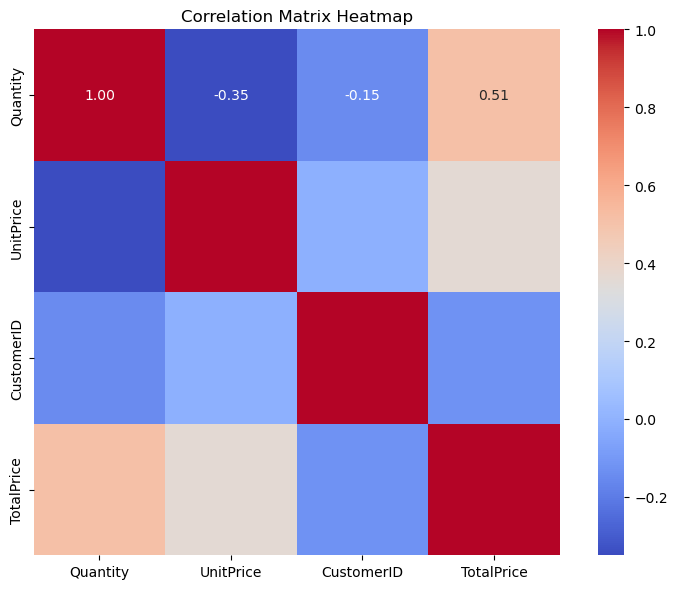

In [22]:
cov_matrix = numerical_df.cov()
corr_matrix = numerical_df.corr()

print("Covariance Matrix:")
print(cov_matrix)

print("")
print("--------------------------")
print("")

print("Correlation Matrix:")
print(corr_matrix)

print("")
print("--------------------------")
print("")

import seaborn as sns
import matplotlib.pyplot as plt

# Size of the plot
plt.figure(figsize=(8, 6))

# Correlation Matrix HeatMap
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", square=True)

plt.title("Correlation Matrix Heatmap")
plt.tight_layout()
plt.show()

<h2 style="color:#d36c87;">1.3. Data reduction</h2>

### Dimensionality reduction

In [42]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

# Select numeric columns
numeric_cols = ['Quantity', 'UnitPrice']
df_pca = df_cleaned[numeric_cols].copy()

# Clean data (remove NaNs or infinities)
df_pca = df_pca.replace([np.inf, -np.inf], np.nan).dropna()

# Standardize data
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df_pca)

# Applying PCA
pca = PCA(n_components=1)
principal_component = pca.fit_transform(scaled_data)

# Store/display the result
df_cleaned['PCA_1D'] = principal_component

print(f"Explained Variance by PCA component: {pca.explained_variance_ratio_[0]:.4f}")


Explained Variance by PCA component: 0.6749


In [43]:
### PCA	Simplifies feature space

### Numerosity reduction

In [44]:
numerosity_df = df_cleaned.groupby('CustomerID').agg({
    'Quantity': 'sum',
    'UnitPrice': 'mean',
    'PCA_1D': 'mean'  # From the PCA step
}).reset_index()

print("Numerosity reduction complete. Dataset reduced to one row per customer.")
display(numerosity_df.head())


Numerosity reduction complete. Dataset reduced to one row per customer.


,CustomerID,Quantity,UnitPrice,PCA_1D
0,12347.0,1893,2.348976,-0.331216
1,12348.0,140,0.650000,-2.352980
2,12349.0,523,2.607759,0.036128
3,12350.0,196,1.581250,-0.770663
4,12352.0,500,3.125152,0.423169


In [45]:
### Group by (Aggregation)	Reduces row count, preserves key info

### Data compression

In [46]:
# Use reduced data
compression_data = numerosity_df[['Quantity', 'UnitPrice']]

# Calc. distance and linkage
distance_matrix = pdist(compression_data)
hierarchy_linkage = linkage(distance_matrix, method='ward')

# Assigning clusters (5)
numerosity_df['Cluster'] = fcluster(hierarchy_linkage, t=5, criterion='maxclust')

print("Data compression complete. Customers assigned to 5 clusters.")
display(numerosity_df[['CustomerID', 'Cluster']].head())


Data compression complete. Customers assigned to 5 clusters.


,CustomerID,Cluster
0,12347.0,5
1,12348.0,3
2,12349.0,3
3,12350.0,3
4,12352.0,3


In [47]:
### Clustering	Compresses customer representation

<h2 style="color:#d36c87;">1.4. Data transformation and data discretization</h2>

---
# 2. Data Visualization